In [25]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

directory='/home/kmatsuno/ShearLayerData/temporal/Mc04/rr1/1024x1448x512/'
# directory = '/home/kmatsuno/ShearLayerData/production/Mc04/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
x = np.linspace(0,Lx,Nx)
z = np.linspace(0,Lz,Nz)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

flist = glob.glob(directory+"*lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 0.4
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['lscale_vv_0002.dat', 'lscale_vv_0003.dat', 'lscale_vv_0004.dat', 'lscale_vv_0005.dat', 'lscale_vv_0006.dat', 'lscale_vv_0007.dat', 'lscale_vv_0008.dat', 'lscale_vv_0009.dat', 'lscale_vv_0010.dat', 'lscale_vv_0011.dat', 'lscale_vv_0012.dat', 'lscale_vv_0013.dat', 'lscale_vv_0014.dat', 'lscale_vv_0015.dat', 'lscale_vv_0016.dat', 'lscale_vv_0017.dat', 'lscale_vv_0018.dat', 'lscale_vv_0019.dat']


0.4: [0.680955104544,0.0439070562884],
0.4: [0.805246412056,0.042923018185],
0.4: [0.802231965689,0.0838303786128],


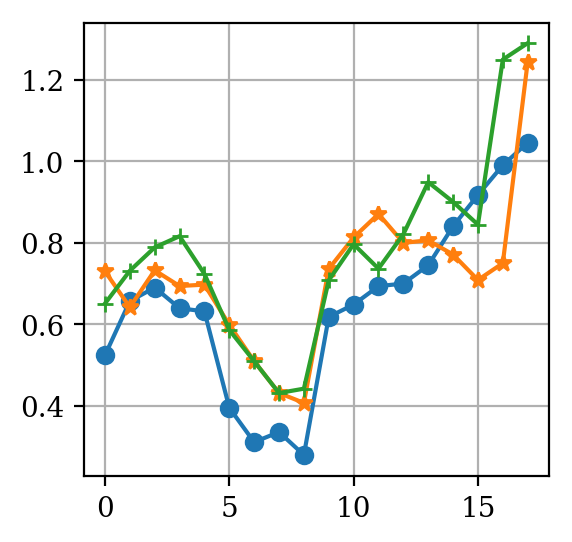

In [28]:
flist = glob.glob(directory+"*lscale_vv*")
t = np.zeros(len(flist))
ly = np.zeros([len(flist),3])

for i,fname in enumerate(flist):
    tID = fname.split('_')[-1]
    tID = int(tID.split('.dat')[0])
    t[i] = nml.read_time(directory,tID)

    # Get eta
    dtheta = get_dtheta(directory,t[i])
    
    # Get L99
    utilde = np.fromfile(directory+'shearlayer_utilde_%04d.dat'%tID,sep=' ')
    L99,tmp1,tmp2 = get_L99(-y,utilde)
    
    # Get ly/L99
    thresh = 0.1
    autocorr = np.fromfile(fname,sep=' ')
    autocorr = np.reshape(autocorr,[Ny,3])
    ly[i,0],tmp1,tmp2 = get_lscale(y,autocorr[:,0],thresh=thresh)/L99
    ly[i,1],tmp1,tmp2 = get_lscale(y,autocorr[:,1],thresh=thresh)/L99
    ly[i,2],tmp1,tmp2 = get_lscale(y,autocorr[:,2],thresh=thresh)/L99

isort = np.argsort(t)
t = t[isort]
ly = ly[isort,:]

plt.figure(figsize=(3,3),dpi=200)
plt.plot(ly[:,0],'-o')
plt.plot(ly[:,1],'-*')
plt.plot(ly[:,2],'-+')
# plt.xlabel('t')
plt.grid(True)

istart = 9
iend = 14
for i in range(3):
    print('{}: [{},{}],'.format(inp.Mc,np.mean(ly[istart:iend,i]),np.std(ly[istart:iend,i])))
